In [ ]:
#Allows relative imports
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
#imports 
from src.preprocessing import *
from src.models import deepcat_cnn
from src.torch_util import *
from src.dataloader import *
from src.train_eval_helpers import *
%load_ext autoreload
%autoreload 2
#checking gpu status
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import BatchSampler, RandomSampler    
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import math

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150
import seaborn as sns
sns.set_style('darkgrid')
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using : {}".format(device))
else:
    device = torch.device('cpu')
    print("Using : {}".format(device))
    
RANGE = range(12,17)
TRAINDIR = '../TrainingData/'
files = os.listdir(TRAINDIR)
files.remove('readme.md')
#Reading data
train_normal = read_seq(TRAINDIR+files[0])
train_tumor = read_seq(TRAINDIR+files[2])

In [6]:
val = 'cv'

if val != 'naive' and val != 'cv':
    print('lol')

In [8]:
from src.models import get_models

In [9]:
test = get_models([12,14,16])

In [5]:
def reload():
    TRAIN_FEATURES, TRAIN_LABELS = generate_features_labels(train_tumor, train_normal,device= None, shuffle=True)
    print("TRAIN TENSORS",TRAIN_FEATURES[12].shape, TRAIN_FEATURES[12].device)
    print("LABELS", TRAIN_LABELS[12].shape, TRAIN_LABELS[12].device)
    
    #Loading models 
    model_dict = {}

    for length in RANGE:
        model = deepcat_cnn(length)
        model_dict[length]=model
        del model
    print(model_dict[12].dummy_param.device)
    return TRAIN_FEATURES, TRAIN_LABELS, model_dict

def shuffle_split(features, target, ratio):
    #shuffling
    indices = torch.randperm(features.size(0))
    data = features[indices]
    labels = target[indices]
    #splitting 
    z = math.ceil((1-ratio)* TRAIN_FEATURES[l].size(0))
    train_data = data[0:z]
    train_labels = labels[0:z]
    test_data = data[z:]
    test_labels = labels[z:]

    return train_data, train_labels, test_data, test_labels

def saveplot(l):
    f, a1 = plt.subplots(figsize=(10,7))
    a2 = a1.twinx()
    
    a1.plot(train_loss_dict[l], 'b-', lw =0.5, label='Train')#, ax=a)
    a2.plot(val_loss_dict[l], 'r-', lw = 0.5, label='Validation')#,ax=a)
    a1.legend(loc='best')
    a2.legend(loc='best')
    a1.set_title('Losses for L = {}'.format(l))
    plt.savefig('fig'+str(l)+'.jpg')
    plt.close(f)
    

In [6]:
TRAIN_FEATURES, TRAIN_LABELS, model_dict = reload()


Data device = cpu
TRAIN TENSORS torch.Size([7379, 1, 15, 12]) cpu
LABELS torch.Size([7379]) cpu
cpu


In [ ]:
from datetime import datetime
TRAIN_FEATURES, TRAIN_LABELS, model_dict = reload()
nb_epochs = 1000
criterion = nn.CrossEntropyLoss()
ratio = 1/4
mini_batch_size = 500

train_loss_dict = {}
val_loss_dict = {}

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)

for l in range(12,17):
    #splits:
    indices = torch.randperm(TRAIN_FEATURES[l].size(0))
    
    z = math.ceil((1-ratio)* TRAIN_FEATURES[l].size(0))
    
    model_dict[l].to(device)

    data_temp = TRAIN_FEATURES[l].detach().clone().to(device)
    labels_temp = TRAIN_LABELS[l].detach().clone().to(device)
    
    train_data, train_target, eval_data, eval_target = shuffle_split(data_temp,
                                                                     labels_temp,
                                                                     ratio)
    
    optimizer = optim.Adam(model_dict[l].parameters(), lr = 0.00125)
    print(model_dict[l].dummy_param.device, train_data.device, eval_target.device)
    train_losses = []
    val_losses = []
    print("\n######L=",l)
    print("TOTAL OF {} samples, {} in train and {} in val.".format(data_temp.size(0),
                                                                   train_data.size(0),
                                                                   eval_data.size(0)))

    for e in range(nb_epochs):

        train_loss = train_model_step(model_dict[l], criterion, optimizer, train_data, train_target, mini_batch_size)
        train_losses.append(train_loss)

        val_loss, _, _ = eval_model(model_dict[l], criterion, eval_data, eval_target)
        val_losses.append(val_loss)
        if e%150==0:print("\nEPOCHS =",e,"\ntrain:",train_loss,"\nVal:",val_loss)
            
    train_loss_dict[l]=train_losses
    val_loss_dict[l]=val_losses
    saveplot(l)
    model_dict[l].to('cpu')
    del TRAIN_FEATURES[l]
    del TRAIN_LABELS[l]
    
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)

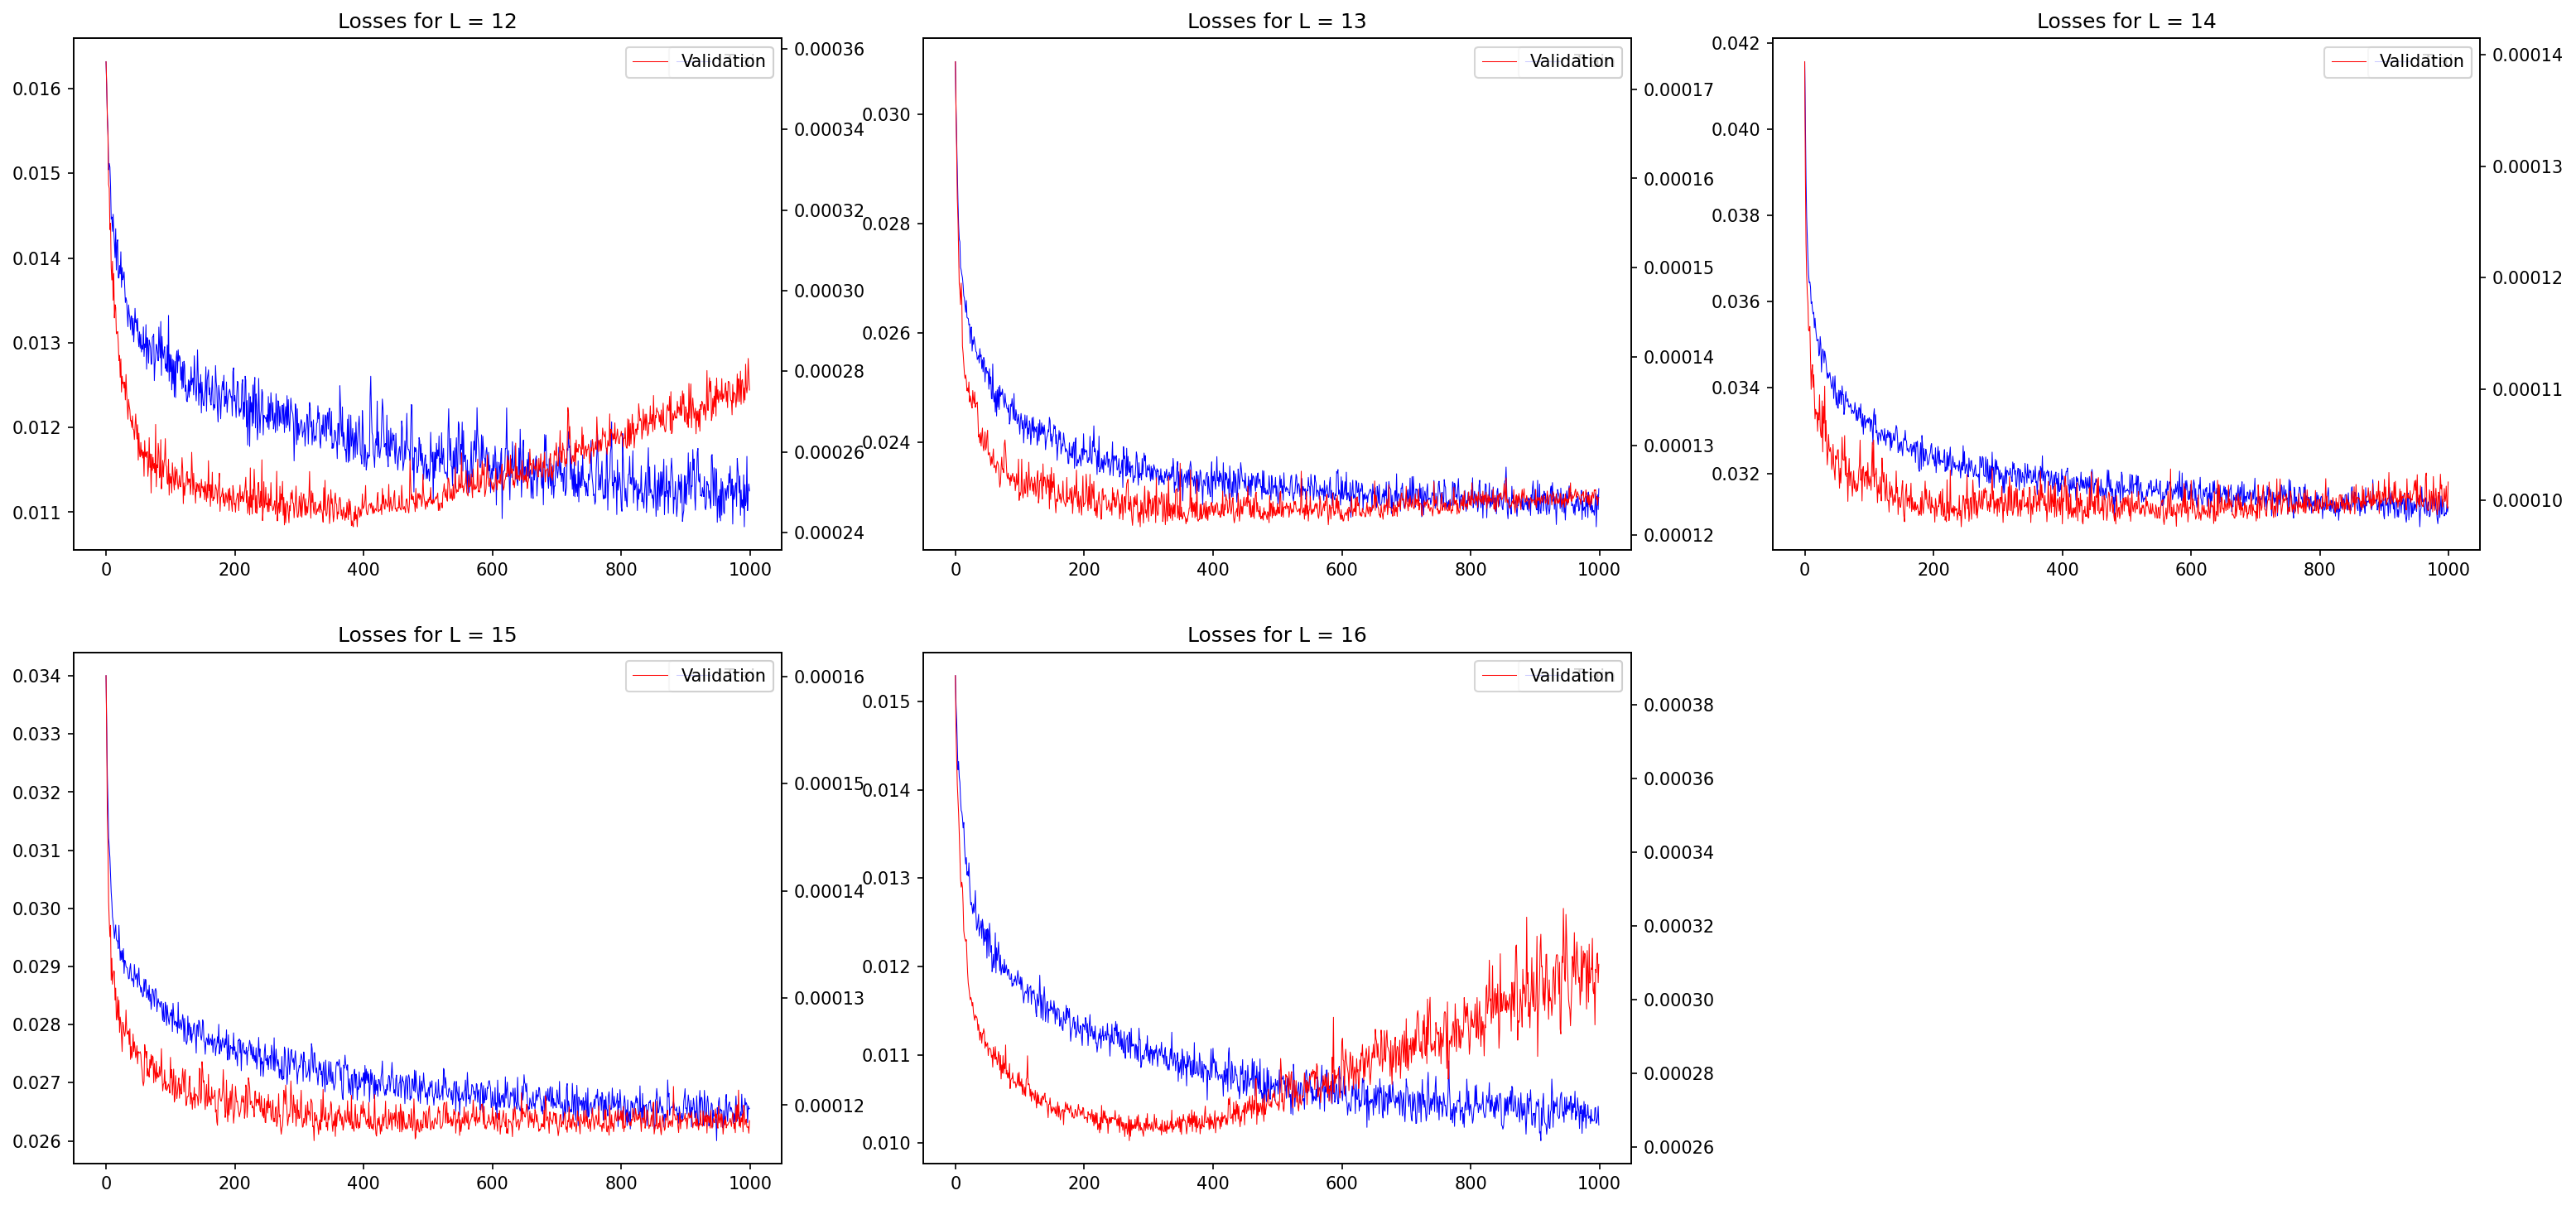

In [5]:
f, a = plt.subplots(2,3, figsize=(25,12))

for index,ll in enumerate(range(12,17)):
    a1 = a.ravel()[index]
    a2 = a1.twinx()
    a1.plot(train_loss_dict[ll], 'b-', lw =0.5, label='Train')#, ax=a)
    a2.plot(val_loss_dict[ll], 'r-', lw = 0.5, label='Validation')#,ax=a)
    a1.legend(loc='best')
    a2.legend(loc='best')
    a1.set_title('Losses for L = {}'.format(ll))
f.delaxes(a.ravel()[-1])
plt.savefig('fig.jpg')

In [15]:
from datetime import datetime
from src.train_eval_helpers import *
from tqdm import tqdm
TRAIN_FEATURES, TRAIN_LABELS, model_dict = reload()

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
nb_epochs = 1000
criterion = nn.CrossEntropyLoss()
ratio = 1/4
mini_batch_size = 250

acc_dict = {}
AUC_dict = {}

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Start Time =", current_time)

for l in range(12,17):
    #splits:
    indices = torch.randperm(TRAIN_FEATURES[l].size(0))
    
    z = math.ceil((1-ratio)* TRAIN_FEATURES[l].size(0))
    
    model_dict[l].to(device)

    data_temp = TRAIN_FEATURES[l].detach().clone().to(device)
    labels_temp = TRAIN_LABELS[l].detach().clone().to(device)
    
    train_data, train_target, eval_data, eval_target = shuffle_split(data_temp,
                                                                     labels_temp,
                                                                     ratio)
    
    optimizer = optim.Adam(model_dict[l].parameters(), lr = 0.00125)
    print(model_dict[l].dummy_param.device, train_data.device, eval_target.device)
    accs = []
    AUCs = []
    print("\n######L=",l)
    print("TOTAL OF {} samples, {} in train and {} in val.".format(data_temp.size(0),
                                                                   train_data.size(0),
                                                                   eval_data.size(0)))
    epoch_print = math.floor(nb_epochs/3)#set an epoch to which we print
    print(epoch_print)
    for e in tqdm(range(nb_epochs)):

        _ = train_model_step(model_dict[l], criterion, optimizer, train_data, train_target, mini_batch_size)
        _, acc, auc = eval_model(model_dict[l], criterion, eval_data, eval_target)
        accs.append(acc)
        AUCs.append(auc)
        if (e%epoch_print==0 or e==nb_epochs):print("\nEPOCHS =",e,"\nAccuracy:",acc,"\nAUC:",auc)
            
    acc_dict[l]=accs
    AUC_dict[l]=AUCs
    
    #saveplot(l)
    model_dict[l].to('cpu')
    del TRAIN_FEATURES[l]
    del TRAIN_LABELS[l]
    
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("End Time =", current_time)

  0%|▏                                                                                      | 2/1000 [00:00<01:29, 11.14it/s]

Data device = cpu
TRAIN TENSORS torch.Size([7379, 1, 15, 12]) cpu
LABELS torch.Size([7379]) cpu
cpu
Start Time = 11:45:57
cuda:0 cuda:0 cuda:0

######L= 12
TOTAL OF 7379 samples, 5535 in train and 1844 in val.
333

EPOCHS = 0 
Accuracy: 0.6160520607375272 
AUC: 0.6386916129545636


 34%|████████████████████████████▌                                                        | 336/1000 [00:25<00:49, 13.32it/s]


EPOCHS = 333 
Accuracy: 0.7863340563991323 
AUC: 0.865601625288454


 50%|██████████████████████████████████████████▉                                          | 505/1000 [00:37<00:37, 13.29it/s]


KeyboardInterrupt: 

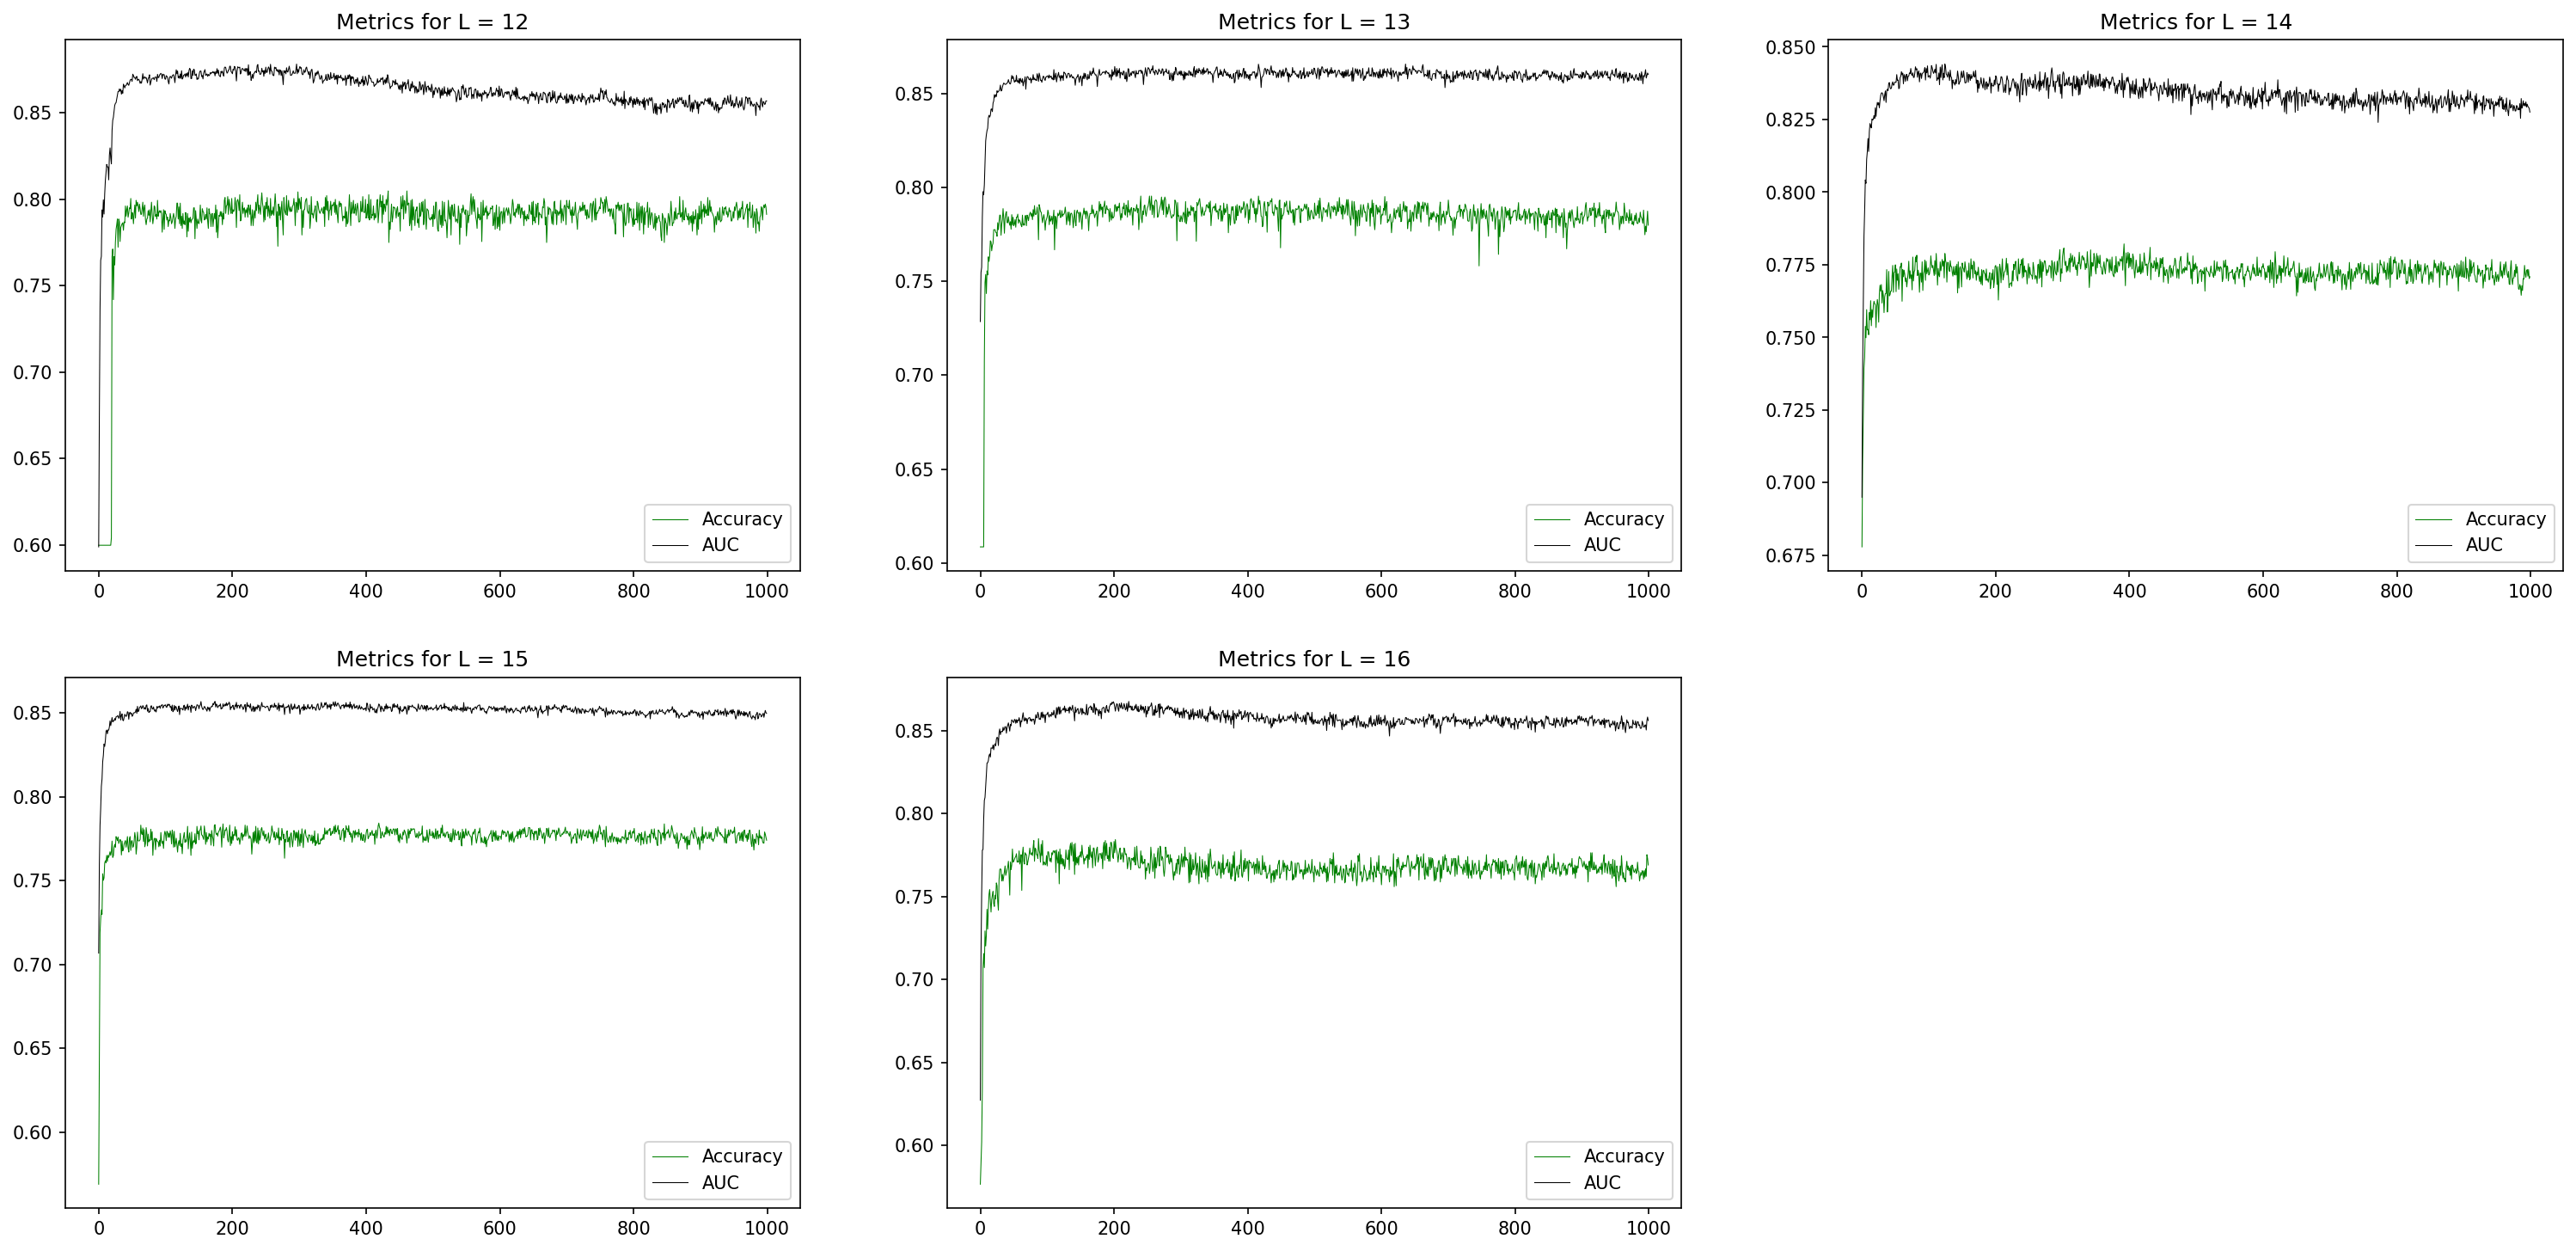

In [12]:
f, a = plt.subplots(2,3, figsize=(25,12))

for index,ll in enumerate(range(12,17)):
    a1 = a.ravel()[index]
    #a2 = a1.twinx()
    a1.plot(acc_dict[ll], 'g-', lw =0.5, label='Accuracy')#, ax=a)
    a1.plot(AUC_dict[ll], 'k-', lw = 0.5, label='AUC')#,ax=a)
    a1.legend(loc='best')
    a1.set_title('Metrics for L = {}'.format(ll))
f.delaxes(a.ravel()[-1])
plt.savefig('acc_fig.jpg')

In [13]:
def get_curve(model, data, labels):
    """
    using sklearn.metrics.roc_curve
    """
    model.eval()
    #one_hot = one_hot_labels(labels).cpu() # from preprocessing.py
    
    #Full test_set in case of unbalanced data
    #Logits = raw for loss, predictions = argmax(logit), probs = softmax(logit)
    logits, _, probs = model(data)
    curve = roc_curve(labels.detach().cpu(), probs.detach().cpu()[:,1], pos_label=1)
    return curve
    
def shuffle(features, target):
    #shuffling
    indices = torch.randperm(features.size(0))
    data = features[indices]
    labels = target[indices]
    return data, labels


In [23]:
epoch_print = math.floor(nb_epochs/3)#set an epoch to which we print
if (e%epoch_print==0 or e==nb_epochs) or e==(nb_epochs-1):pass

In [25]:
nb_epochs-1

99

In [29]:
#Testing whether my train_model_full works 
#splits:
l = 12
ratio = 1/4

model_dict[l].to(device)

data_temp = TRAIN_FEATURES[l].detach().clone().to(device)
labels_temp = TRAIN_LABELS[l].detach().clone().to(device)

train_data, train_target, eval_data, eval_target = shuffle_split(data_temp,
                                                                 labels_temp,
                                                                 ratio)
print(len(train_data),len(eval_data))
optimizer = optim.Adam(model_dict[l].parameters(), lr = 0.00125)
criterion = nn.CrossEntropyLoss()
nb_epochs=100
mbs = 100
train_model_full(model_dict[l], criterion, optimizer, nb_epochs,
                 train_data, train_target, eval_data, eval_target, mbs, verbose=True)

  0%|                                                                                                | 0/100 [00:00<?, ?it/s]

5535 1844
Current stats at epoch = 0 :
Train loss = 0.5162497130307284
 Val loss = 0.372419148683548
 Acc = 0.8459869848156182
AUC = 0.9294117137486249

  2%|█▊                                                                                      | 2/100 [00:00<00:17,  5.47it/s]

 35%|██████████████████████████████▍                                                        | 35/100 [00:05<00:10,  6.07it/s]

Current stats at epoch = 33 :
Train loss = 0.48825154467062515
 Val loss = 0.3607999384403229
 Acc = 0.8264642082429501
AUC = 0.9157338758679752


 54%|██████████████████████████████████████████████▉                                        | 54/100 [00:09<00:07,  5.86it/s]


KeyboardInterrupt: 

In [17]:
#Reloading training set
TRAIN_FEATURES, TRAIN_LABELS, model_dict = reload()
#loading test sets as well
test_normal = read_seq(TRAINDIR+files[1])
test_tumor = read_seq(TRAINDIR+files[3])
test_features, test_label = generate_features_labels(test_tumor, test_normal, None, True)
curve_dict = {}
aucs_dict = {}

train_losses = {}
nb_epochs = 200
mini_batch_size = 200
#Retraining from scratch
for ls in range(12,17):
    model_dict[ls].to(device)
    train_data = TRAIN_FEATURES[ls].detach().clone().to(device)
    train_target = TRAIN_LABELS[ls].detach().clone().to(device)
    optimizer = optim.Adam(model_dict[ls].parameters(), lr = 0.00125)
    criterion = nn.CrossEntropyLoss()
    losses = []
    for e in range(nb_epochs):        
        loss = train_model_step(model_dict[ls], criterion, optimizer, train_data, train_target, mini_batch_size)
        losses.append(loss)
        
    train_losses[ls] = losses
    
    data, labels = shuffle_data(test_features[ls], test_label[ls])
    data = data.to(device)
    labels = labels.to(device)
    print(data.device)
    _,_, auc= eval_model(model_dict[ls], criterion, data, labels)
    aucs_dict[ls]= auc
    curve_dict[ls] = get_curve(model_dict[ls], data, labels)

TRAIN TENSORS torch.Size([7379, 1, 15, 12]) cpu
LABELS torch.Size([7379]) cpu
cpu
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0


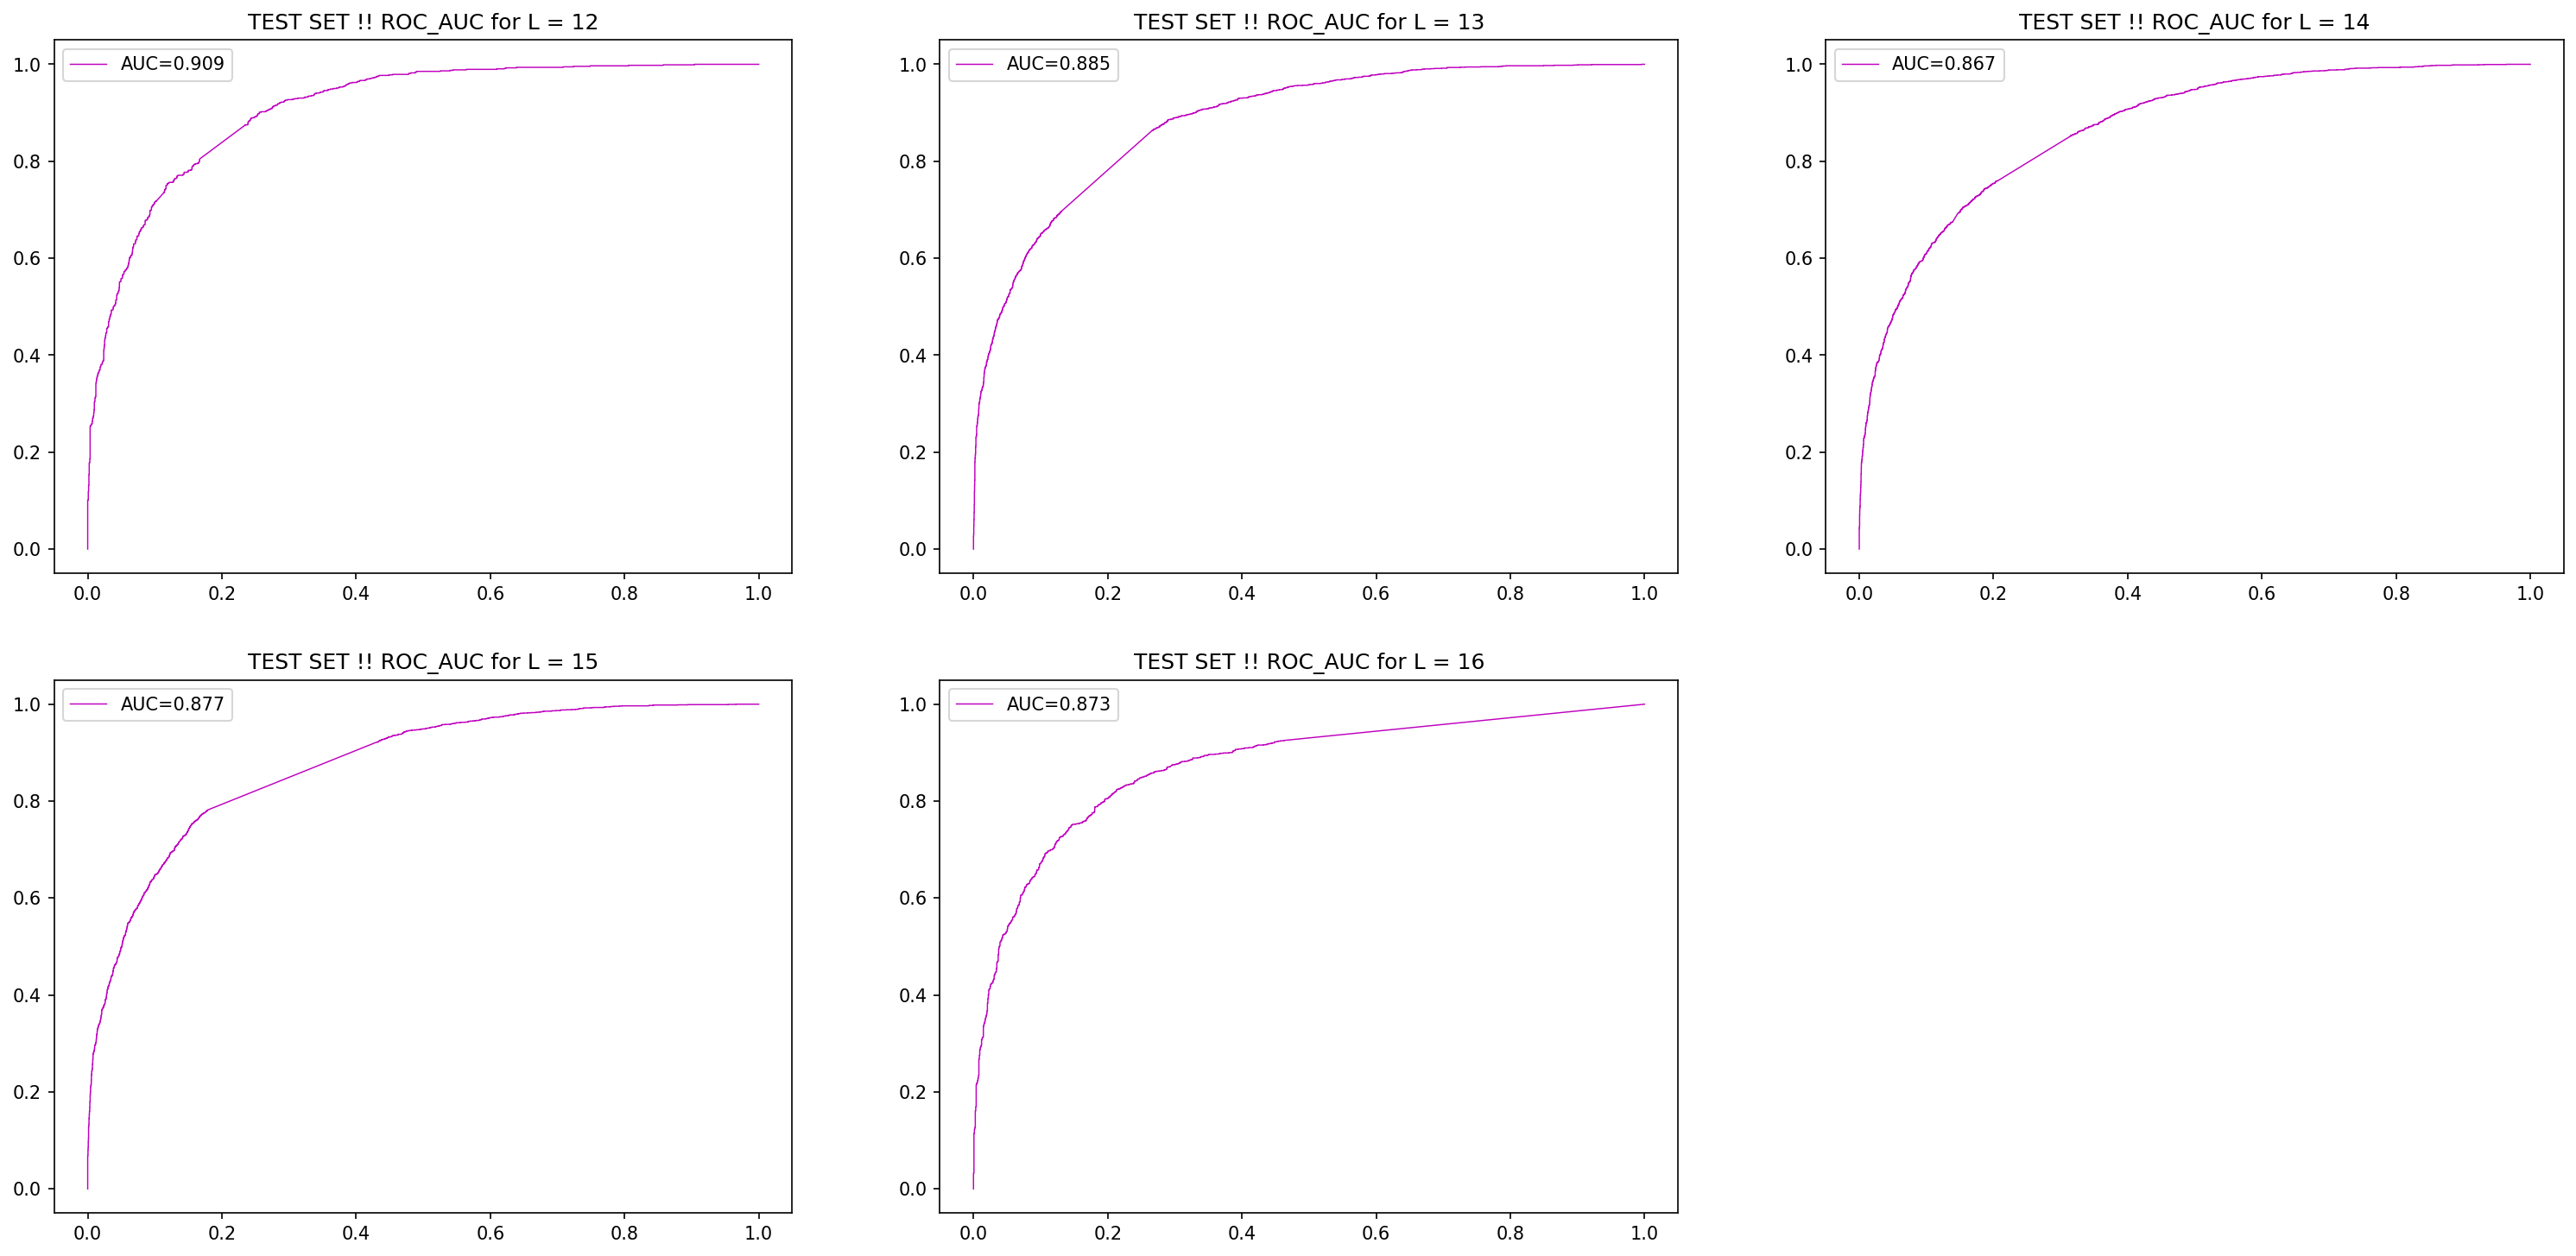

In [18]:
f, a = plt.subplots(2,3, figsize=(25,12))

for index,ll in enumerate(range(12,17)):
    a1 = a.ravel()[index]
    #a2 = a1.twinx()
    a1.plot(curve_dict[ll][0],curve_dict[ll][1], 'm-', lw =0.7, label='AUC={:.3f}'.format(aucs_dict[ll]))
    #a1.plot(AUC_dict[ll], 'k-', lw = 0.5, label='AUC')#,ax=a)
    a1.legend(loc='best')
    a1.set_title('TEST SET !! ROC_AUC for L = {}'.format(ll))
f.delaxes(a.ravel()[-1])
plt.savefig('retest_AUC.jpg')

In [26]:
#Checking some stuff with curve L=14
data, labels = shuffle_data(test_features[14], test_label[14])
data=data.to(device)
labels=labels.to(device)
logits, preds, probs = model_dict[14](data)
_,_, auc = eval_model(model_dict[14], criterion, data, labels)
CURVE = get_curve(model_dict[14], data, labels)
#plt.plot(CURVE[0], CURVE[1])
len(labels[labels==1]), len(preds[preds==1])

(2399, 2465)

In [46]:
from sklearn.metrics import precision_score 
preds_dict = {}
for ll in range(12,17):
    y_true = test_label[ll].to(device)
    X = test_features[ll].to(device)
    _, preds, _ = model_dict[ll](X)
    preds_dict[ll]=preds
    print("For L = {}, the precision is : {}".format(ll, 
                                                     precision_score(y_true.detach().cpu(), 
                                                                     preds.detach().cpu())))
    

For L = 12, the precision is : 0.7510869565217392
For L = 13, the precision is : 0.7056431113370615
For L = 14, the precision is : 0.6567951318458418
For L = 15, the precision is : 0.7253975075204125
For L = 16, the precision is : 0.7289603960396039


In [37]:
print("For the training set :")
for ll in range(12,17):
    print("Proportion of positive class for L = {}, = {:.2%}".format(ll,len(TRAIN_LABELS[ll][TRAIN_LABELS[ll]==1])/len(TRAIN_LABELS[ll])))
    
print("For the test set :")
for ll in range(12,17):
    print("Proportion of positive class for L = {}, = {:.2%}".format(ll,len(test_label[ll][test_label[ll]==1])/len(test_label[ll])))

For the training set :
Proportion of positive class for L = 12, = 39.38%
Proportion of positive class for L = 13, = 39.24%
Proportion of positive class for L = 14, = 37.31%
Proportion of positive class for L = 15, = 43.57%
Proportion of positive class for L = 16, = 56.24%
For the test set :
Proportion of positive class for L = 12, = 30.20%
Proportion of positive class for L = 13, = 31.07%
Proportion of positive class for L = 14, = 28.29%
Proportion of positive class for L = 15, = 33.47%
Proportion of positive class for L = 16, = 47.51%


In [65]:
df_pred = pd.DataFrame(columns=['ll','y_true','predicted'])#,'tp','fp','tn','fn'])

In [117]:
a=test_label[12].view(-1,1)
b=preds_dict[12].detach().cpu().view(-1,1)
lens = torch.full((len(test_label[12]),1), 12)
a.shape, b.shape, lens.shape
tmp_data = torch.cat((lens,a,b),1)
df1 = pd.DataFrame(data=tmp_data.numpy(), columns = ['ll','y_true','predicted'])
df1.head(3)

,ll,y_true,predicted
0,12,0,0
1,12,0,0
2,12,1,0


In [ ]:
for 

In [207]:
for z in model_dict.keys():
    print(z)

12
13
14
15
16


In [229]:
def get_pred_df(model_dict, data_dict, target_labels_dict):
    RANGE = model_dict.keys()
    df = pd.DataFrame(columns = ['seqlen','y_true','predicted','prob_cancer',
                                 'tp','fp','tn','fn'])
    for ll in RANGE:
        #seqlen = ll.value
        mod = model_dict[ll].to('cuda')
        X = data_dict[ll].to('cuda') #data
        y_true = target_labels_dict[ll] #y_true
        _, preds, probs = model_dict[ll](X)
        tmp_data = torch.cat((torch.full((len(preds),1), ll),#seqlen
                              y_true.view(-1,1).cpu(),#y_true
                              preds.detach().cpu().view(-1,1), #predicted
                              probs.detach().cpu()[:,1].view(-1,1)),
                             1)#cat dimension
        
        tmp = pd.DataFrame(data=tmp_data.numpy(),
                           columns =['seqlen','y_true','predicted','prob_cancer'])
        tmp['tp'] = tmp.apply(lambda x: 1 if (x['y_true']==x['predicted'] and x['predicted']==1) else 0, axis=1)
        tmp['fp'] = tmp.apply(lambda x: 1 if (x['y_true']!=x['predicted'] and x['predicted']==1) else 0, axis=1)
        tmp['tn'] = tmp.apply(lambda x: 1 if (x['y_true']==x['predicted'] and x['predicted']==0) else 0, axis=1)
        tmp['fn'] = tmp.apply(lambda x: 1 if (x['y_true']!=x['predicted'] and x['predicted']==0) else 0, axis=1)
        df = pd.concat([df,tmp], ignore_index=True)
    df=df.astype({'seqlen': 'int64', 'y_true':'int64','predicted':'int64',
                 'tp':'int64','fp':'int64','tn':'int64','fn':'int64'},copy=True)
    df.reset_index()
    return df

In [230]:
test_features, test_label = generate_features_labels(test_tumor, test_normal, None, True)
df = get_pred_df(model_dict, test_features, test_label)
display(df.sample(5)), df.dtypes

,seqlen,y_true,predicted,prob_cancer,tp,fp,tn,fn
25676,16,0,0,0.289945,0,0,1,0
9169,13,1,0,0.500000,0,0,0,1
8842,13,0,0,0.294941,0,0,1,0
26284,16,0,0,0.289945,0,0,1,0
24652,15,1,0,0.356146,0,0,0,1


(None,
 seqlen           int64
 y_true           int64
 predicted        int64
 prob_cancer    float32
 tp               int64
 fp               int64
 tn               int64
 fn               int64
 dtype: object)

In [226]:
import numpy as np
x =np.cumsum(df['tp'].values)/np.cumsum(np.ones(len(df['tp'])))
#plt.plot(range(0,len(df['tp'])), x, label = 'num_pos:'+str(np.sum(y_true==1))+ 
#'num_tot:'+str(len(y_test)) )

In [337]:
xs=df.sort_values('prob_cancer',ascending=False)\
  .groupby('seqlen')\
  .apply(lambda x: np.cumsum(x['tp'].values)/np.cumsum(np.ones(len(x['tp']))))

perfect = df.sort_values('y_true',ascending=False)\
  .groupby('seqlen')\
  .apply(lambda x: np.cumsum(x['y_true'].values)/np.cumsum(np.ones(len(x['y_true']))))

In [338]:
display(perfect[14])

array([1.        , 1.        , 1.        , ..., 0.28293431, 0.28290094,
       0.28286759])

In [344]:
f, a = plt.subplots(figsize=(15,9))#2,3, figsize=(18,9))
#ax = a.ravel()
line = ['c--','r--','g--', 'b--', 'm--']
for i, sl in enumerate(xs.index):
    a.semilogx(range(0,len(df.query('seqlen==@sl')['tp'])), xs[sl], 
                   line[i], lw=1, label='L={}'.format(sl))
a.legend(loc='best')
a.set_title('PPV vs (TP+FP)',weight='bold')
a.set_ylabel('PPV')
a.set_xlabel('Number of predictions (logscale)')
#a.ygrid()
plt.grid(True, which="both", ls="-.", color='0.8')
plt.savefig('PPV.jpg')
plt.close()

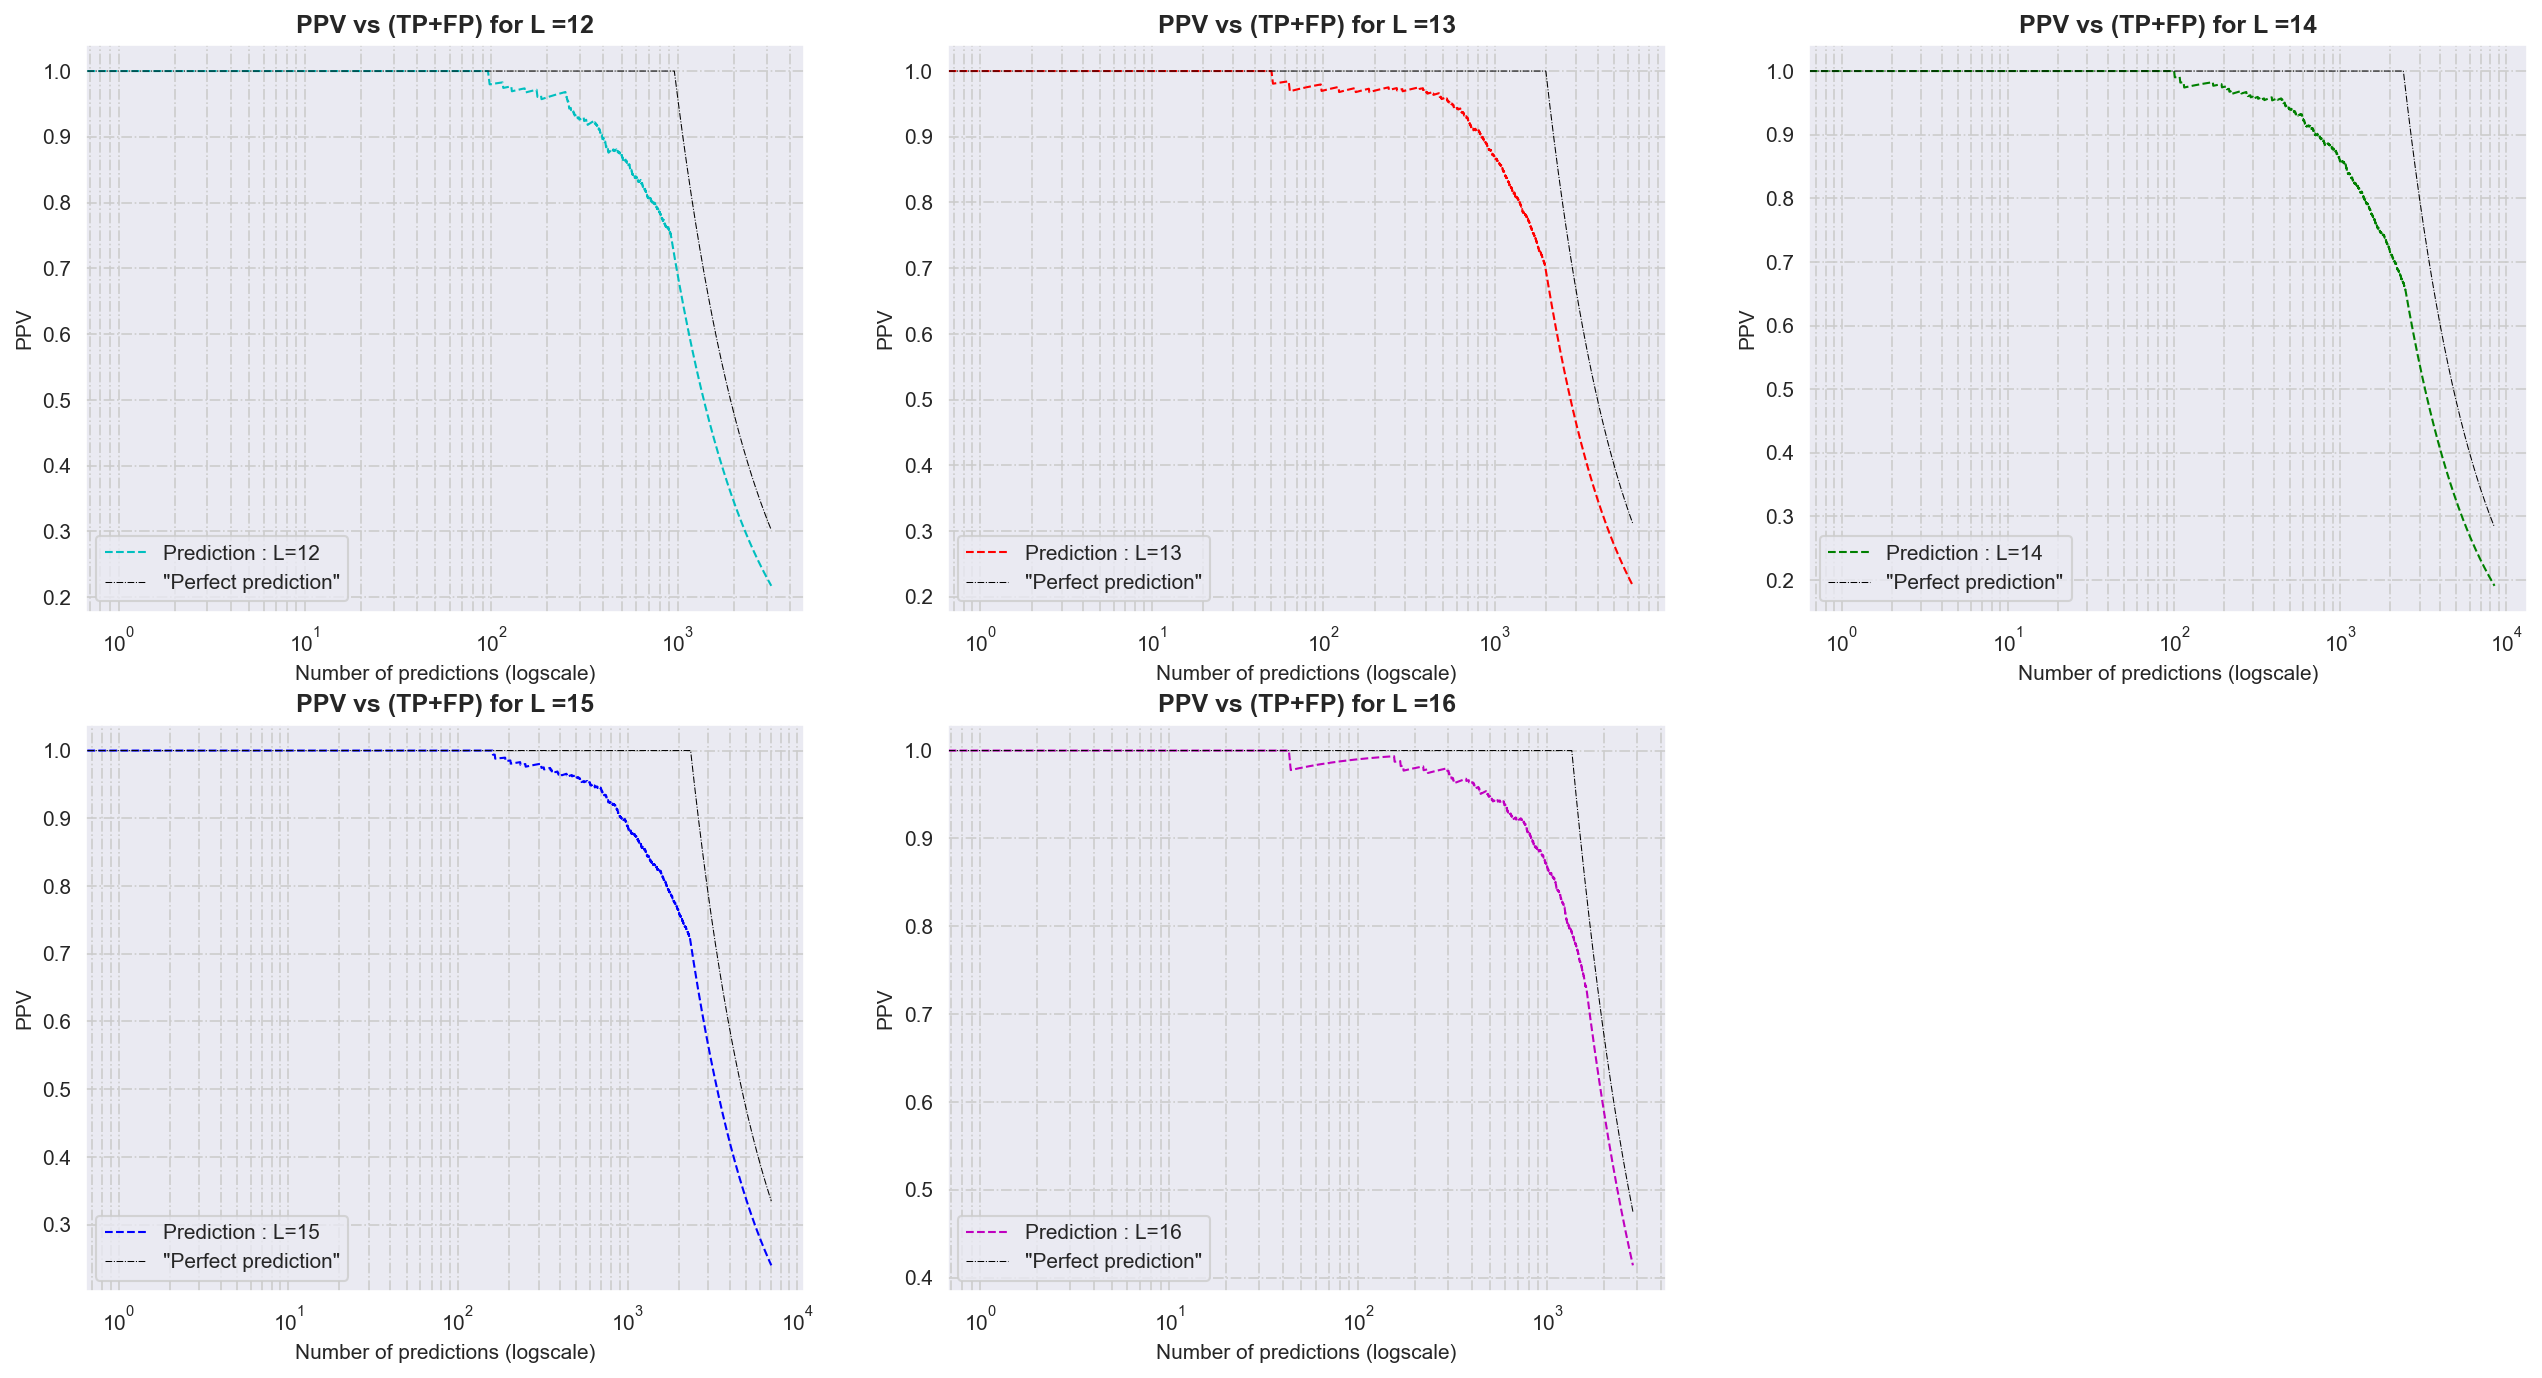

In [352]:
f, a = plt.subplots(2,3, figsize=(21,11))
ax = a.ravel()
line = ['c--','r--','g--', 'b--', 'm--']
for i, sl in enumerate(xs.index):
    ax[i].semilogx(range(0,len(df.query('seqlen==@sl')['tp'])), xs[sl], 
                   line[i], lw=1, label='Prediction : L={}'.format(sl))
    ax[i].semilogx(range(0,len(df.query('seqlen==@sl')['y_true'])), perfect[sl],
                   'k-.', lw=0.5, label = '"Perfect prediction"')
    ax[i].legend(loc='best')
    ax[i].set_title('PPV vs (TP+FP) for L ={}'.format(sl), weight='bold')
    ax[i].set_ylabel('PPV')
    ax[i].set_xlabel('Number of predictions (logscale)')
#a.ygrid()
    ax[i].grid(True, which="both", ls="-.", color='0.8')
f.delaxes(ax[-1])
plt.savefig('PPV_with_true.jpg')